In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.CIFAR10(root='../Data/', train=True, download=True, transform=transform)

Files already downloaded and verified


In [4]:
test_data = datasets.CIFAR10(root='../Data/', train=False, download=True, transform=transform)

Files already downloaded and verified


In [5]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [9]:
for images,labels in train_loader:
    break

In [10]:
labels

tensor([1, 5, 8, 1, 6, 1, 6, 3, 7, 9])

label: [1 5 8 1 6 1 6 3 7 9]
class:   car   dog  ship   car  frog   car  frog   cat horse truck


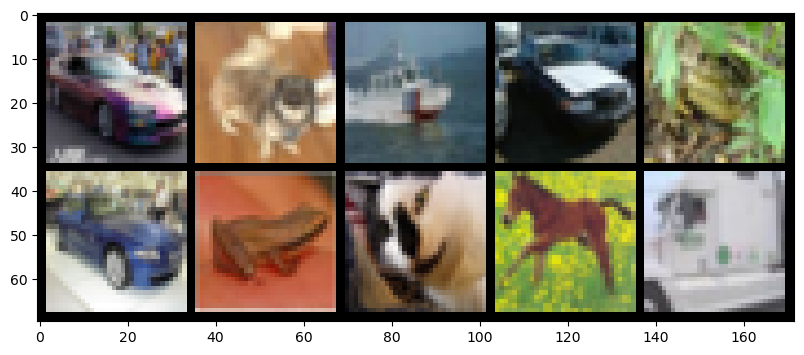

In [11]:
# print labels
print('label:', labels.numpy())
print('class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images,nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [12]:
images[0].shape

torch.Size([3, 32, 32])

In [13]:
((32-2)/2-2)/2 # how to get 6 for fc1 (6*6*16, 120)

6.5

In [14]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1) # (input channels, output channels, kernel size, stride)
        self.conv2 = nn.Conv2d(6, 16, 3, 1) # usually reduce kernel size
        self.fc1 = nn.Linear(6*6*16, 120) # 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2) # (kernel size, stride)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X,dim=1)

In [15]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch: 1000 [ 10000/50000]  loss: 2.12254381  accuracy:  26.450%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.87852168  accuracy:  32.580%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.00479102  accuracy:  35.897%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.21432662  accuracy:  37.995%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.46198106  accuracy:  39.752%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.32197285  accuracy:  48.770%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.18050802  accuracy:  49.085%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.34127152  accuracy:  49.760%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 0.91763324  accuracy:  50.172%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.88918912  accuracy:  50.686%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.52225780  accuracy:  54.040%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.47507453  accuracy:  53.915%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.50267768  accuracy:  54.687%
epoch:  2  b

In [19]:
torch.save(model.state_dict(), 'myCIFARmodel.pt')

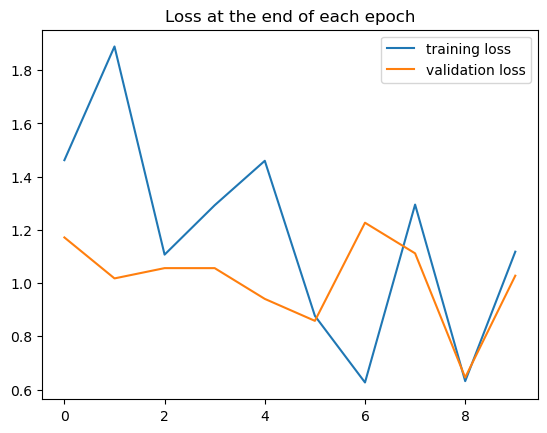

In [20]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

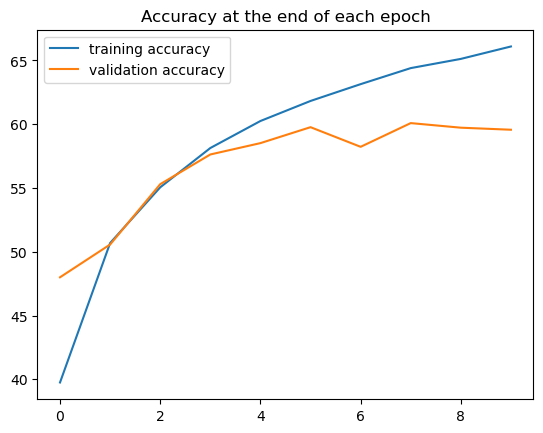

In [21]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [22]:
print(test_correct)

[tensor(4800), tensor(5057), tensor(5530), tensor(5763), tensor(5852), tensor(5977), tensor(5823), tensor(6009), tensor(5973), tensor(5957)]


In [24]:
num_correct = test_correct[-1].item()

In [25]:
num_correct*100/10000

59.57

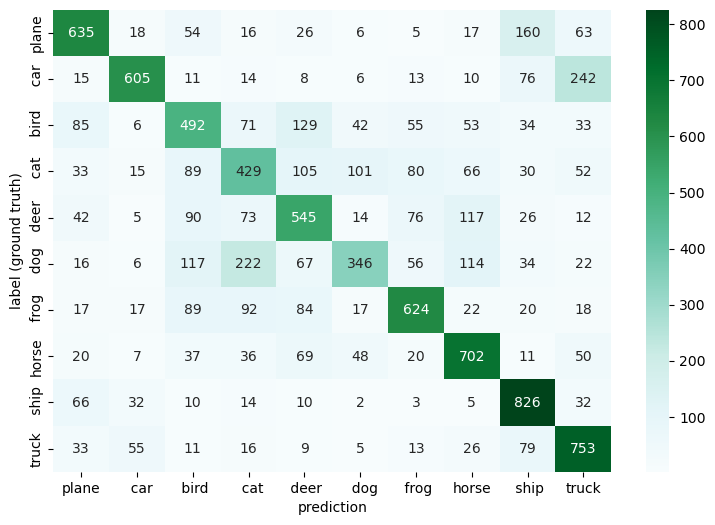

In [26]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();